CCD Lab

SBID# 113181913 

Co-authors: SBID# 113164004, SBID# 113827547

Affiliations: Department of Physics and Astronomy, Stony Brook University, Stony Brook, NY 11794, USA

In [147]:
#importing all necessary packages for the code
import matplotlib.pyplot as plt
from astropy.nddata import CCDData
from astropy.io import fits
from ccdproc import *
from astropy.visualization import hist
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
from pathlib import Path
import astroalign as aa

4.1.1 
To begin the data analysis, first open the .FIT file of the bias frame taken at 0◦C. This can be done using astropy or CCDData, in this case, I chose to use CCDData as I am more familiar with that package. Since the FIT file has array data, it is necessary to flatten the data into a 1D array in order to create plots. To cut the hot pixels out of the bias frame, we must first plot a histogram depicting the number of pixels versus the pixel value, which corresponds to the photon counts. Any columns that appear to be far from the evident Gaussian distribution of data correspond to hot pixels and should be cut from the image using array math. By only plotting pixel values less than the decided cut, in this case, 2000, you should see a histogram with a clear Gaussian distribution of the photon counts. Then, determine the fraction of pixels that get rejected when cutting the data. This can be done with a simple for loop that counts each pixel that appears in the data after the pixel value at the end of your Gaussian distribution. Dividing this value by the length of the array will give you the fraction of pixels rejected by the cut. 

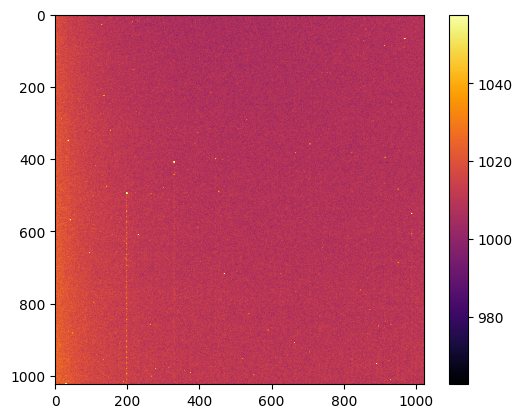

In [148]:
#4.1.1 - Opening the image for bias frame at 0◦C using CCDData
#Plot image using matplotlib
bias_image = CCDData.read('bias_frame.00000000.BIAS.FIT', unit='adu')
plt.imshow(bias_image.data, cmap='inferno', vmin = np.mean(bias_image.data) - 3*(np.std(bias_image.data)), 
            vmax = np.mean(bias_image.data) + 3*(np.std(bias_image.data)))
plt.colorbar()

4.1.1
There are clear hot pixels in the image that are visible to the naked eye. The most evident is depicted at (200, 530)

[]

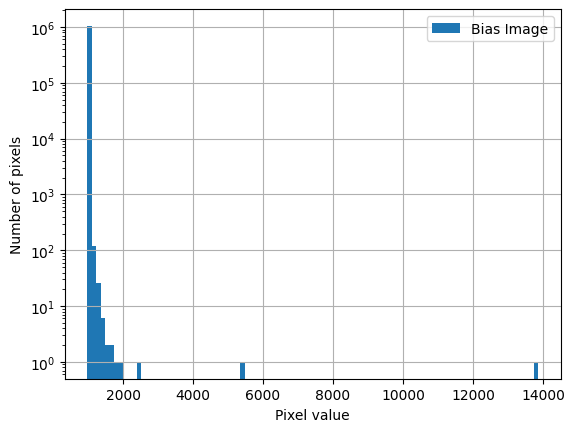

In [149]:
#4.1.1 - Plotting the histogram of the distribution of counts for the bias frame
#Plot Histogram
data = bias_image.data.flatten()
hist(data, bins=100, label='Bias Image')
plt.grid()
plt.legend()
plt.xlabel('Pixel value')
plt.ylabel('Number of pixels')
plt.semilogy() #y-axis in log-scale

Text(0, 0.5, 'Number of pixels')

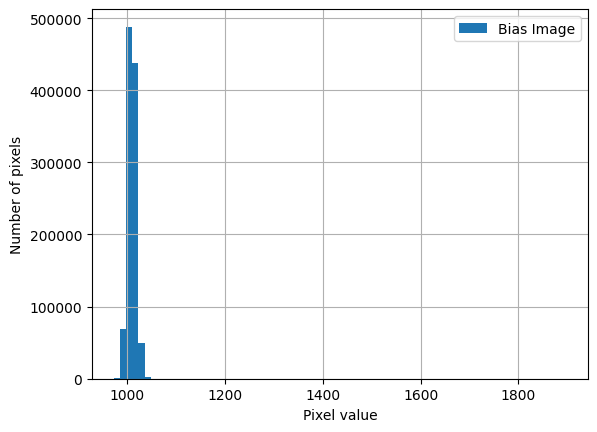

In [150]:
#4.1.1 - Defining a cut that rejects any hot pixels and plotting the cut histogram 
#Plot Cut Histogram 
data_cut = data[data<2000]
hist(data_cut, bins=75, label='Bias Image')
plt.grid()
plt.legend()
plt.xlabel('Pixel value')
plt.ylabel('Number of pixels')

In [151]:
#Fraction of Pixels that get rejected
# The for loop iterates through the length of the data and adds to the count for every 
#     data point greater than 1060 
count = 0
for i in range(len(data)):
    if bias_image.data.flatten()[i] > 1060:
        count = count + 1
print(f"The fraction of pixels that got rejected is {count / len(data)}")

The fraction of pixels that got rejected is 0.0003871917724609375


4.1.2
To find a Gaussian fit of the bias frame data, first, find the standard deviation and mean of the cut data. The standard deviation is a measure of the read noise in counts within the range specified by the cut. From this data, we can then plot the Gaussian curve of best fit over the bias image histogram. Then, a simple conversion can be done to transform the standard deviation into read noise in units of electrons.

In [152]:
#4.1.2
#Calculate the standard deviation and mean for Gaussian Curve
# using built in numpy functions
std = np.std(data_cut)
print(f'standard deviation is {std}')
mean = np.mean(data_cut)
print(f'mean is {mean}')
uncert = std/(1024)
# 1024 is the size of the data
print(f'uncertainity is: {uncert}')

standard deviation is 8.499324106312372
mean is 1010.1403488359895
uncertainity is: 0.008300121197570676


In [153]:
#Define the Gaussian Function
def g(sigma,u,x):
    return 1/(sigma*(np.sqrt(2*np.pi))) * np.exp(-(x - u)**2 / (2*sigma**2))

Text(0, 0.5, 'Number of pixels')

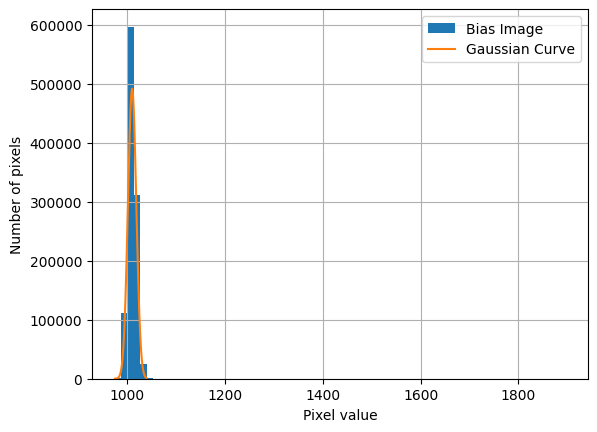

In [154]:
#4.1.2 
#Plot Cut Histogram with Gaussian Fit
x = np.linspace(975,1040,1040)
hist(data_cut, bins=70, label='Bias Image')
plt.plot(x, 10485760*g(std,mean,x), label='Gaussian Curve')
plt.grid()
plt.legend()
plt.xlabel('Pixel value')
plt.ylabel('Number of pixels')

$$\text{read noise} = \frac{\sigma \times \text{gain}}{\sqrt{2}}$$

In [155]:
#4.1.2
#Bias method for read noise
bias_data_cut = data_cut
read_noise = np.std(bias_data_cut) * 2.06/ np.sqrt(2)
print(f"Read noise: {read_noise}")

Read noise: 12.380455204816089


4.1.2 
The read noise the the random noise that is generated while measuring the number of electrons in each pixel, and then converting them to counts. The value from the calculation of this data set, 12.38, is fairly consistent to the manufacturer's given value of 14.8.

4.2.1
To analyze the dark frames, we must first make a median combine of the ten images that have the same exposure time, in this case, 30 seconds. Print the master dark frame and note any visible hot pixels. 

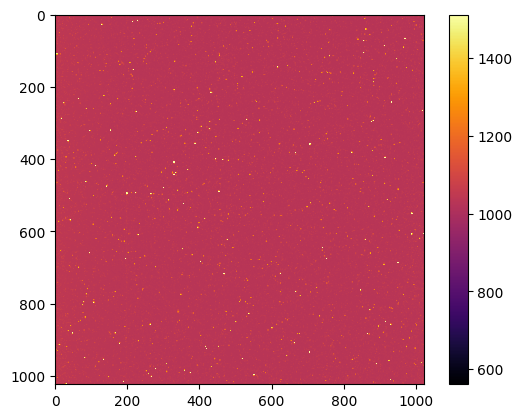

In [215]:
#4.2.1
#Combining 10 dark images with 30s exposure time and finding the median combine
ccd1 = CCDData.read('dark_frame_30s.06.DARK.FIT', unit='adu')
ccd2 = CCDData.read('dark_frame_30s.07.DARK.FIT', unit='adu')
ccd3 = CCDData.read('dark_frame_30s.08.DARK.FIT', unit='adu')
ccd4 = CCDData.read('dark_frame_30s.09.DARK.FIT', unit='adu')
ccd5 = CCDData.read('dark_frame_30s.10.DARK.FIT', unit='adu')
ccd6 = CCDData.read('dark_frame_30s.11.DARK.FIT', unit='adu')
ccd7 = CCDData.read('dark_frame_30s.12.DARK.FIT', unit='adu')
ccd8 = CCDData.read('dark_frame_30s.13.DARK.FIT', unit='adu')
ccd9 = CCDData.read('dark_frame_30s.14.DARK.FIT', unit='adu')
ccd10 = CCDData.read('dark_frame_30s.15.DARK.FIT', unit='adu')

combiner = Combiner([ccd1, ccd2, ccd3, ccd4, ccd5, ccd6, ccd7, ccd8, ccd9, ccd10])
combined_median = np.array(combiner.median_combine())

#Making new FIT file from median array
hdu = fits.PrimaryHDU(combined_median)
hdul = fits.HDUList([hdu])
hdu.writeto('master_dark_frame_30s.DARK.FIT', overwrite = True)

#Print the Master Dark Frame
dark_image = CCDData.read('master_dark_frame_30s.DARK.FIT', unit='adu')
plt.imshow(dark_image.data, cmap='inferno', vmin = np.mean(dark_image.data) - 3*(np.std(dark_image.data)), 
            vmax = np.mean(dark_image.data) + 3*(np.std(dark_image.data)))
plt.colorbar()

Each pixel that is brighter than the background is defined as a hot pixel

[]

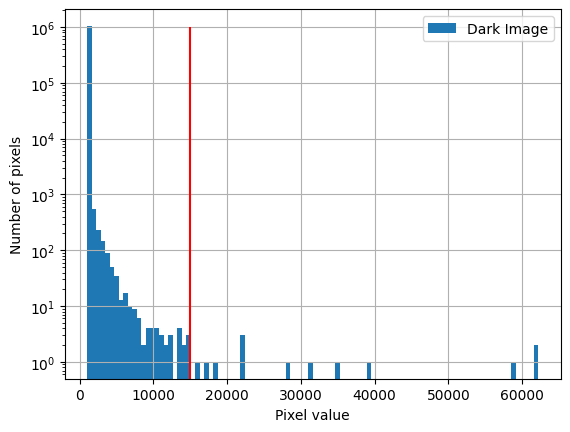

In [159]:
#4.2.1
#Plot Master Dark Frame Histogram and define a cut of the data
dark0 = dark_image.data.flatten()
hist(dark0, bins=100, label='Dark Image')
plt.grid()
plt.vlines(15000,0,1e6, colors='red') # a vertical line to help determine where the cut should be
plt.legend()
plt.xlabel('Pixel value')
plt.ylabel('Number of pixels')
plt.semilogy() #y-axis in log-scale

Note the significant hot pixels that appear after the vertical red line defining the cut. 

[]

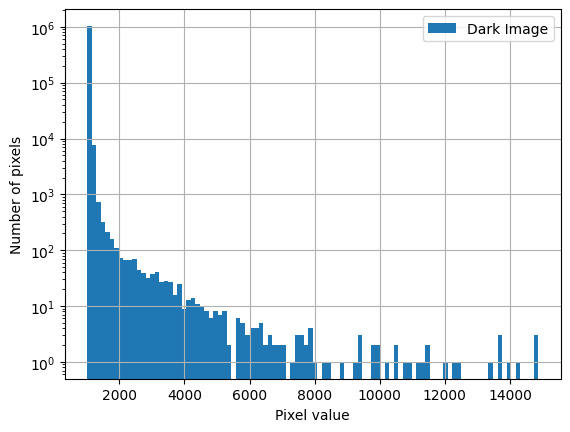

In [160]:
#4.2.1
#Plot the Cut Histogram of the Master Dark Frame
dark_cut0 = dark0[dark0<15000]
hist(dark_cut0, bins=100, label='Dark Image')
plt.grid()
plt.legend()
plt.xlabel('Pixel value')
plt.ylabel('Number of pixels')
plt.semilogy() #y-axis in log-scale

4.2.2
From the dark frame time series, find the mean, standard deviation, and uncertainty of the cut data for each frame. The exposure time for the time series is 10 seconds, 60 seconds, 90 seconds, and 120 seconds. One of the previously taken dark frames was also used in the calculations that has an exposure time of 30 seconds. Estimate the systematic uncertainty by changing the cut of the data and determining which data set has a lower uncertainty. Next, plot the mean counts versus the exposure time for the dark frames at 0◦C, including error bars. A linear regression can then plot a best fit line for the data and determine if it is a good fit by making a residual plot. From the best fit data, compute the dark current in electrons per pixel per second. Repeat these steps for the dark frame at 10◦C.

In [161]:
#4.2.2 - Opening and reading each dark frames in the time series
ccd11 = CCDData.read('dark_frame_10s.DARK.FIT', unit='adu')
dark_10s = ccd11.data.flatten()
dark_10s_cut = dark_10s[dark_10s < 15000]
dark_30s = ccd10.data.flatten()
dark_30s_cut = dark_30s[dark_30s < 15000]
ccd12 = CCDData.read('dark_frame_60s.DARK.FIT', unit='adu')
dark_60s = ccd12.data.flatten()
dark_60s_cut = dark_60s[dark_60s < 15000]
ccd13 = CCDData.read('dark_frame_90s.DARK.FIT', unit='adu')
dark_90s = ccd13.data.flatten()
dark_90s_cut = dark_90s[dark_90s < 15000]
ccd14 = CCDData.read('dark_frame_120s.DARK.FIT', unit='adu')
dark_120s = ccd14.data.flatten()
dark_120s_cut = dark_120s[dark_120s < 15000]

In [162]:
#Mean, Standard Deviation and Uncertainty for 10s Dark Frame
mean10 = np.mean(dark_10s_cut)
std10 = np.std(dark_10s_cut)
uncert10 = std10/(np.sqrt(1024**2))
print(f'The mean of the data is: {mean10}')
print(f'The standard deviation of the data is: {std10}')
print(f'The uncertainty of the data is: {uncert10}')

The mean of the data is: 1016.6903954231132
The standard deviation of the data is: 43.874405847985756
The uncertainty of the data is: 0.04284609946092359


In [163]:
#Mean, Standard Deviation and Uncertainty for 30s Dark Frame
mean30 = np.mean(dark_30s_cut)
std30 = np.std(dark_30s_cut)
uncert30 = std30/1024

In [164]:
#Mean, Standard Deviation and Uncertainty for 60s Dark Frame
mean60 = np.mean(dark_60s_cut)
std60 = np.std(dark_60s_cut)
uncert60 = std60/(np.sqrt(1024**2))
print(f'The mean of the data is: {mean60}')
print(f'The standard deviation of the data is: {std60}')
print(f'The uncertainty of the data is: {uncert60}')

The mean of the data is: 1062.4348267285184
The standard deviation of the data is: 141.38562569891172
The uncertainty of the data is: 0.13807190009659348


In [165]:
#Mean, Standard Deviation and Uncertainty for 90s Dark Frame
mean90 = np.mean(dark_90s_cut)
std90 = np.std(dark_90s_cut)
uncert90 = std90/(np.sqrt(1024**2))
print(f'The mean of the data is: {mean90}')
print(f'The standard deviation of the data is: {std90}')
print(f'The uncertainty of the data is: {uncert90}')

The mean of the data is: 1089.553274709344
The standard deviation of the data is: 181.85343252655036
The uncertainty of the data is: 0.17759124270170934


In [166]:
#Mean, Standard Deviation and Uncertainty for 120s Dark Frame
mean120 = np.mean(dark_120s_cut)
std120 = np.std(dark_120s_cut)
uncert120 = std120/(np.sqrt(1024**2))
print(f'The mean of the data is: {mean120}')
print(f'The standard deviation of the data is: {std120}')
print(f'The uncertainty of the data is: {uncert120}')

The mean of the data is: 1115.7015448681325
The standard deviation of the data is: 213.62654431281496
The uncertainty of the data is: 0.20861967218048336


In [167]:
#4.2.2 
#create an array of each mean 
mean_counts = np.array([mean, mean10, mean30, mean60, mean90, mean120])

#create an array of each exposure time
exp_time = np.array([0, 10, 30, 60, 90, 120]) 

#create an array of the uncertainty values
yerr = np.array([uncert, uncert10, uncert60, uncert60, uncert90, uncert120])

1008.9943566861658 0.8905671674047515


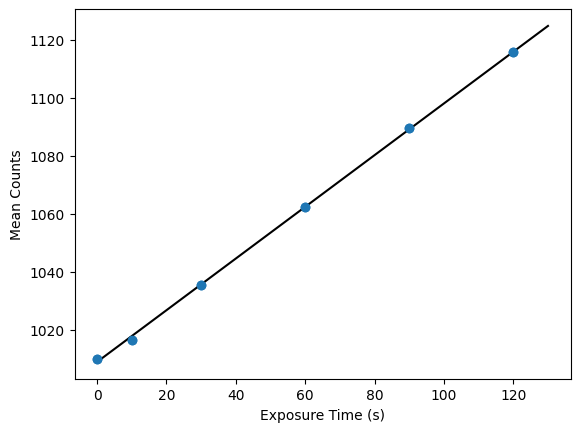

In [168]:
#4.2.2 
#make a scatter plot of the mean counts versus the exposure time
plt.scatter(exp_time, mean_counts)
b, a = np.polyfit(exp_time, mean_counts, deg=1)
xseq = np.linspace(0, 130, 6)
plt.plot(xseq, a + b * xseq, color="k", lw=1.5)

#add error bars into the plot
plt.errorbar(exp_time, mean_counts, yerr = yerr, fmt='o')
plt.xlabel('Exposure Time (s)')
plt.ylabel('Mean Counts')
print(a,b)
# note that the errors are of scale 0.04, which is much too small to be seen in the graph

Text(0, 0.5, 'Residual')

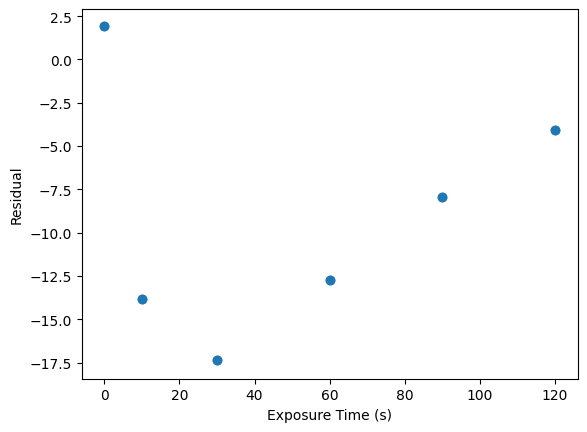

In [169]:
#4.2.2 - Plot of the residuals of the data points, with uncertainties
def residual(a,b, xseq):
    return mean_counts - (a + b * xseq)

plt.scatter(exp_time, residual(1008.2142894895652,0.8582815152075286, xseq)) 
# values of a and b taken from the best fit line plotted above

yerr = np.array([uncert, uncert10, uncert60, uncert60, uncert90, uncert120])
plt.errorbar(exp_time, residual(1008.2142894895652,0.8582815152075286, xseq), yerr = yerr, fmt='o')

plt.xlabel('Exposure Time (s)')
plt.ylabel('Residual')

Since the data is randomly scattered above and below the line of best fit, the plot demonstrates a good description of the data.  

In [170]:
#Dark Current in electrons per pixel per second, 2.06 is given as the gain
dark_current = 2.06 * b
print(dark_current)

1.834568364853788


4.2.2
The dark current occurs when electrons tunnel into the conduction band without any incoming light. This imitates a signal when there should not be one. A dark current of 1.835 is considered to be within the same magnitude of the manufacturer's value of 9 because the current technology becomes less accurate over time.

[]

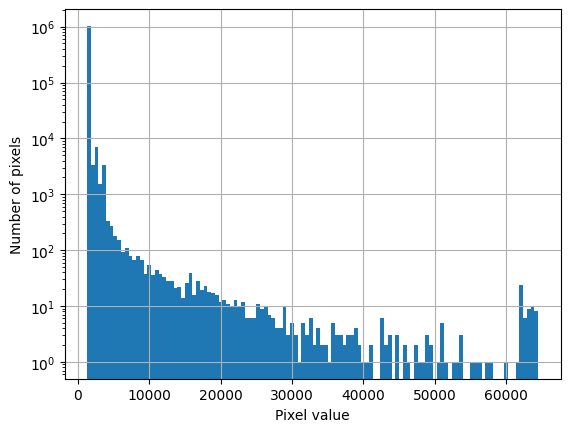

In [171]:
#4.2.2 - Reading in the Dark frame at 10◦C
# exposure time 120s
ten_celsius = CCDData.read('dark_frame_tenC.20.DARK.FIT', unit='adu')
celsius = ten_celsius.data.flatten()
header = dict(fits.open('dark_frame_tenC.20.DARK.FIT')[0].header)
exp_time = header.get('EXPTIME')

dark_10 = ten_celsius.data.flatten()
plt.hist(dark_10, bins=120)
plt.grid()
plt.xlabel('Pixel value')
plt.ylabel('Number of pixels')
plt.semilogy()

In [172]:
# cut the data from the dark fram at 10 deg Celsius to remove hot pixels
# calculate the dark current of the cut data
dark_10_cut = dark_10[dark_10 < 40000]
dark_current_10 = 2.06*(np.mean(dark_10_cut)/exp_time)
print(f"The dark current of the frame at 10 deg C is:", dark_current_10)

The dark current of the frame at 10 deg C is: 25.760170620046356


4.2.2 The dark current for the data including the dark frame taken at 10◦C, calculated to be 25.76, is significantly higher than the previously calculated dark current of 1.834. This is because the dark current is affected by the thermal excitations of electrons in the CCD. So, as the temperature increases, the vibrations of the electrons also increase and thus the dark current will be higher.

4.3.1
Make a median combine of the flat field images and normalize them to a typical count level. To normalize, divide the combined median by the mean of the data. 

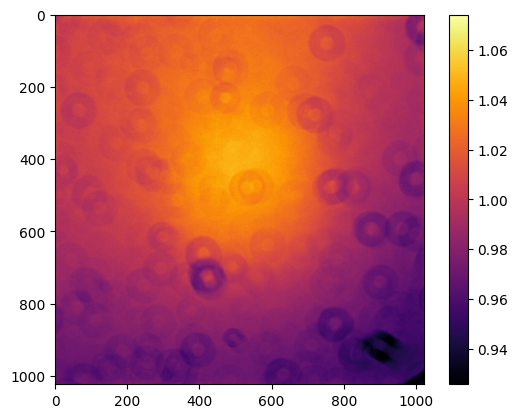

In [216]:
#4.3.1
#Reading in the Flat-field Images, combining to take the median of the ten flat fields and normalizing it for the master flat-field
flat1 = CCDData.read('flat_fields_frame.00000005.FIT', unit='adu')
flat2 = CCDData.read('flat_fields_frame.00000006.FIT', unit='adu')
flat3 = CCDData.read('flat_fields_frame.00000007.FIT', unit='adu')
flat4 = CCDData.read('flat_fields_frame.00000008.FIT', unit='adu')
flat5 = CCDData.read('flat_fields_frame.00000009.FIT', unit='adu')
flat6 = CCDData.read('flat_fields_frame.00000010.FIT', unit='adu')
flat7 = CCDData.read('flat_fields_frame.00000011.FIT', unit='adu')
flat8 = CCDData.read('flat_fields_frame.00000012.FIT', unit='adu')
flat9 = CCDData.read('flat_fields_frame.00000013.FIT', unit='adu')
flat10 = CCDData.read('flat_fields_frame.00000014.FIT', unit='adu')

combiner_flats = Combiner([flat1, flat2, flat3, flat4, flat5, flat6, flat7, flat8, flat9, flat10])
combined_median_flats = np.array(combiner_flats.median_combine())
mean_flats = np.mean(combined_median_flats)
normed = combined_median_flats/mean_flats

#Making new FIT file from median array
hdu_flats = fits.PrimaryHDU(normed)
hdul_flats = fits.HDUList([hdu_flats])
hdu_flats.writeto('normed_master_flat.FIT', overwrite = True)

#Master flat-field
flat_image = CCDData.read('normed_master_flat.FIT', unit='adu')
plt.imshow(flat_image.data, cmap='inferno', vmin = np.mean(flat_image.data) - 3*(np.std(flat_image.data)), 
            vmax = np.mean(flat_image.data) + 3*(np.std(flat_image.data)))
plt.colorbar()

4.3.2
In uploading the image to Ds9 and hovering the mouse over the dimmest section of the master flat field, as well as the brightest section, we can determine the fraction of the intensity of the light. This calculates to be $$\frac{0.922219}{1.04341} = 0.883$$

4.3.3 - If one was to place the same star first into the center of the image, and then close to one of the dimmer corners, the “observed” magnitude of the star closer to the corner would be $0.883$ times brighter than the star closer to the bright center.

4.3.4 
Plot a histogram of the counts in the master flat-field and note any dead pixels.

Text(0, 0.5, 'Number of pixels')

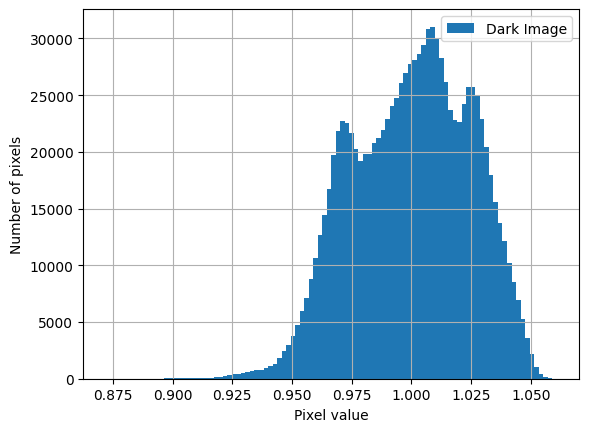

In [176]:
#4.3.4 - Plotting a histogram of the flat-field
hist(flat_image.data.flatten(), bins=100, label='Dark Image')
plt.grid()
plt.legend()
plt.xlabel('Pixel value')
plt.ylabel('Number of pixels')

4.3.5 - It is important to note that if the flat fields were not taken on the night of the observations, they cannot be retaken later. This is because the environment changes and can affect the flat field image.

4.4.1
The spectrograph has 3 slits, with widths 25µm, 35µm and 50µm. The 50µm slit corresponds to the bottommost section, the 25µm slit is depicted in the center, and the 35 slit is the uppermost section. For the calibrations, the 25µm slit was utilized.

4.4.2
Using array math, cut out the images to 
keep only the data fromthe 25µm slitt.The take a median combine of the data andnm Make a plot of the 1d flat-field values against the pixel positions along t e
dispersion axis.

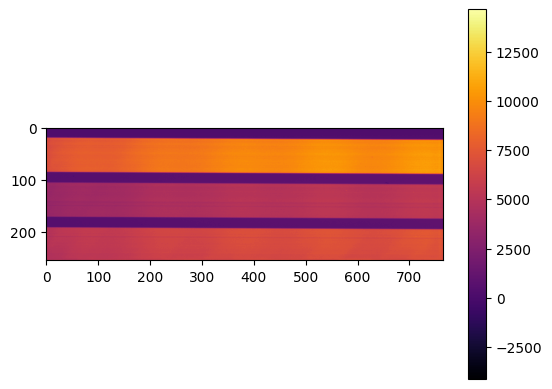

In [177]:
# 4.4.2 - reading in the flat field of the spectrum and showing the image
flat_spectro = CCDData.read('flat_fields.00000007.FIT', unit='adu')
plt.imshow(flat_spectro.data,  cmap='inferno', vmin = np.mean(flat_spectro.data) - 3*(np.std(flat_spectro.data)), 
            vmax = np.mean(flat_spectro.data) + 3*(np.std(flat_spectro.data)))
plt.colorbar()

In [178]:
#4.4.2 - Cutting out the images to keep only the data from the target slit of 50µm
flat_spectro = flat_spectro.data[106:176, :]

In [211]:
#4.4.2 - Making new FIT file from median array
hdu_flats2 = fits.PrimaryHDU(flat_spectro)
hdul_flats2 = fits.HDUList([hdu_flats2])
hdu_flats2.writeto('cut_spec.FIT', overwrite = True)

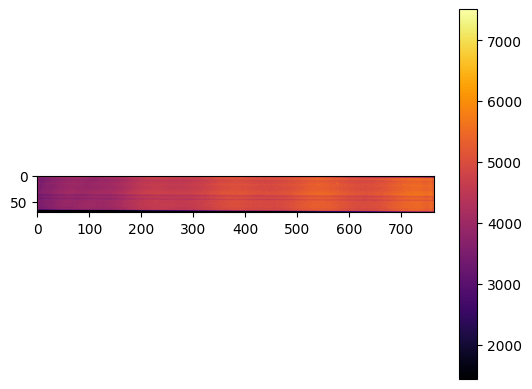

In [180]:
#4.4.2 - Displaying the cut spectrum image
spec_image = CCDData.read('cut_spec.FIT', unit='adu')
plt.imshow(spec_image.data, cmap='inferno', vmin = np.mean(spec_image.data) - 3*(np.std(spec_image.data)), 
            vmax = np.mean(spec_image.data) + 3*(np.std(spec_image.data)))
plt.colorbar()

Text(0, 0.5, 'Intensity')

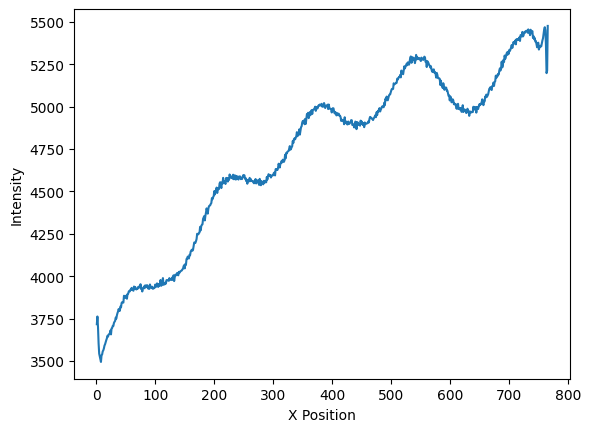

In [228]:
#4.4.2 - plot of the 1D flat field values against the pixel positions along the dispersion axis 
intensity = np.median(spec_image.data, axis = 0)
x_pos = np.linspace(1,765,765)
plt.plot(x_pos, intensity)
plt.xlabel('X Position')
plt.ylabel('Intensity')

4.4.3
It is necessary to normalize the flat field in order minimize the chances of having different levels of sensativity, or brightness, across the various frames. Normalize the flat field by plotting a low-order polynomial fit over the 1d spectrum data. Then, divide the 2d flat fieled by the best fit equation. 

Text(0, 0.5, 'Intensity')

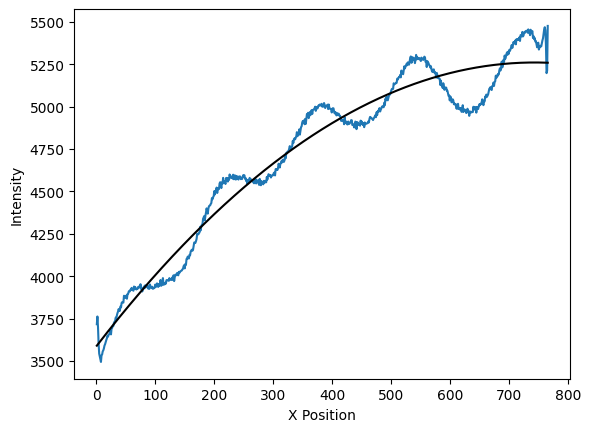

In [229]:
#4.4.3 - a low order polynomial fit of the flat field data in order to normalize
a, b, c = np.polyfit(x_pos, intensity, deg=2)
xseq = np.linspace(1, 765, 765)
plt.plot(x_pos, intensity)
plt.plot(x_pos, a * xseq **2 + b*xseq + c, color="k", lw=1.5)
plt.xlabel('X Position')
plt.ylabel('Intensity')

In [230]:
# normalized flat field image
norm_flat = spec_image.data/(a * xseq**2 + b*xseq + c)
hdu_norm = fits.PrimaryHDU(norm_flat)
hdul_norm = fits.HDUList([hdu_norm])
hdu_norm.writeto('normed_cut_spec.FIT', overwrite = True)

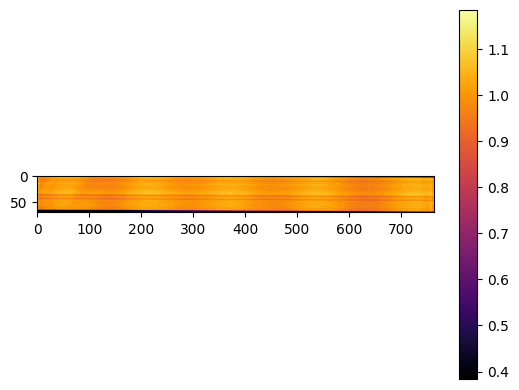

In [231]:
# read in the normed flat field image and print using matplotlib
norm_flat_image = CCDData.read('normed_cut_spec.FIT', unit='adu')
plt.imshow(norm_flat_image.data, cmap='inferno', vmin = np.mean(norm_flat_image.data) - 3*(np.std(norm_flat_image.data)))
plt.colorbar()

4.4.3
The normalized flat field of the arc lamp spectrum is noticeably different from the original image. The colorbar of the image transforms into a range from 0.4-1.1. These values make it easier to read and understand the spectrograph. It is also possible to note the changes in the heatmap of the image, clearly depicting a wave of alternating light and dark values. 

4.4.4
Cut out the arc lamp spectrum of the 50µm slit and apply the normalized flat field to the arc lamp spectrum.

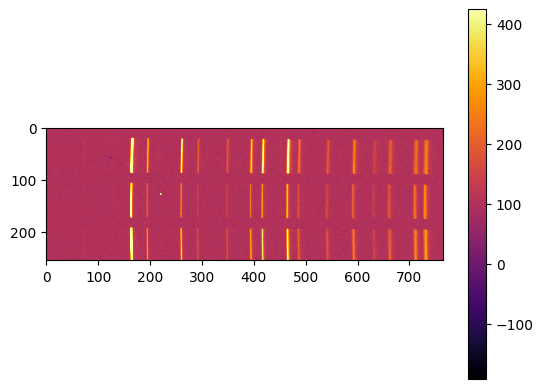

In [232]:
#4.4.4 - reading in the arc lamp flat field
flat_arclamp = CCDData.read('arc_lamp_spectrum.00000002.FIT', unit='adu')
plt.imshow(flat_arclamp.data, cmap='inferno', vmin = np.mean(flat_arclamp.data) - 3*(np.std(flat_arclamp.data)), 
            vmax = np.mean(flat_arclamp.data) + 3*(np.std(flat_arclamp.data)))
plt.colorbar()

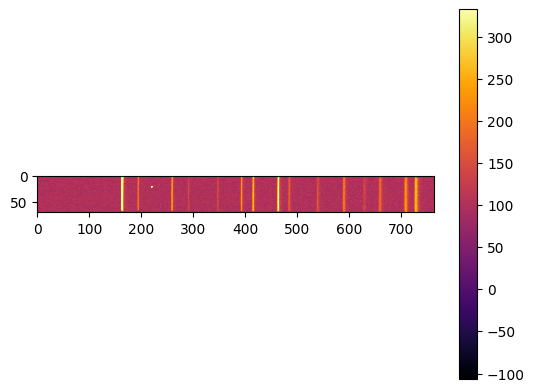

In [233]:
#4.4.4 cutting the image 
flat_arclamp = flat_arclamp.data[106:176, :]

#creating a new file for the cut image
hdu_flats2 = fits.PrimaryHDU(flat_arclamp)
hdul_flats2 = fits.HDUList([hdu_flats2])
hdu_flats2.writeto('cut_arclamp.FIT', overwrite = True)

#reading in the cut image
arclamp_image = CCDData.read('cut_arclamp.FIT', unit='adu')
plt.imshow(arclamp_image.data, cmap='inferno', vmin = np.mean(arclamp_image.data) - 3*(np.std(arclamp_image.data)), 
            vmax = np.mean(arclamp_image.data) + 3*(np.std(arclamp_image.data)))
plt.colorbar()

In [236]:
#normalizing the cut data
normed_spec = arclamp_image.data/(a * xseq **2 + b*xseq + c)
#creating a new file for the cut and normalized data
hdu_flats3= fits.PrimaryHDU(normed_spec)
hdul_flats3 = fits.HDUList([hdu_flats3])
hdu_flats3.writeto('cut_arclamp_normed.FIT', overwrite = True)

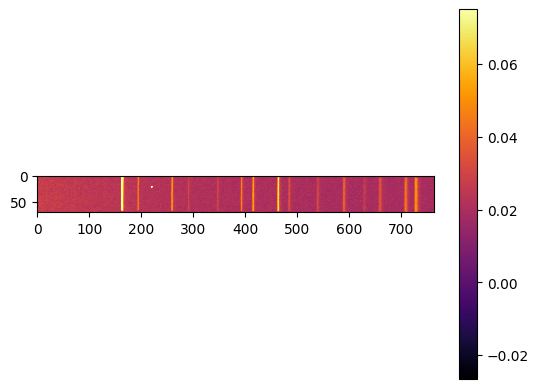

In [237]:
#reading in the normalized image of the arc lamp spectrum
cut_arclamp_normed = CCDData.read('cut_arclamp_normed.FIT', unit='adu')
plt.imshow(cut_arclamp_normed.data, cmap='inferno', vmin = np.mean(cut_arclamp_normed.data) - 3*(np.std(cut_arclamp_normed.data)), 
            vmax = np.mean(cut_arclamp_normed.data) + 3*(np.std(cut_arclamp_normed.data)))
plt.colorbar()

4.4.5
Next, the wavelength from the arc lamp spectrum must be calibrated. In order to do this first open the image in ds9 and record the pixel value for each emission line in the normed arc lamp spectrum. Then, find an example wavelength for neon's emission lines. Create an array of these two data sets and make a plot of the wavelength versus pixel position with a line of best fit. Create a plot of the residuals to check the accuracy of the data. 

In [192]:
#4.4.5 
# creating an array of the pixel values for each emission line in the normed arc lamp spectrum 
# values taken from Ds9
pixel_value_spec = np.array([164.829, 195.5, 260.894, 292.722, 348.856, 417.144, 465.755, 486, 588, 541.565, 
                             593.648, 630.685, 662.514, 711.125, 732.537])

# creating an array of an example wavelength for neon's emission lines (wavelength in nm)
# values taken from google
ex_wavelength = np.array([540.1, 585.2, 588.2, 603.0, 607.4, 616.4, 621.7, 626.6, 633.4, 638.3, 640.2, 650.6, 
                          659.9, 692.9, 703.2])

527.3100020855768 0.21115308647968006


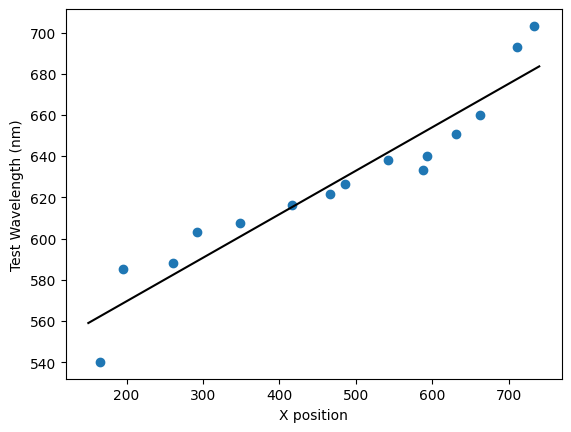

In [193]:
#4.4.5 - plotting the wavelength vs pixel position with a best fit line
plt.scatter(pixel_value_spec, ex_wavelength)
b, a = np.polyfit(pixel_value_spec, ex_wavelength, deg=1)
xseq = np.linspace(150, 740, 15)
plt.plot(xseq, a + b * xseq, color="k", lw=1.5)
plt.xlabel('X position')
plt.ylabel('Test Wavelength (nm)')
print(a,b)

Text(0, 0.5, 'Test Wavelength (nm)')

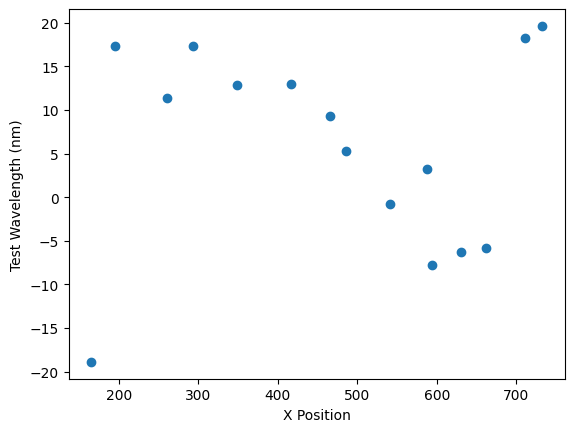

In [194]:
#4.4.5 plotting the residuals of the above plot
def residual(a,b, xseq):
    return ex_wavelength - (a + b * xseq)

plt.scatter(pixel_value_spec, residual(527.3100020855768, 0.21115308647968006, xseq))
plt.xlabel('X Position')
plt.ylabel('Test Wavelength (nm)')

4.4.6
Plot the calibrated spectrum and label a few of the Neon emission lines.

[558.98296506 567.88155942 576.78015378 585.67874813 594.57734249
 603.47593685 612.37453121 621.27312557 630.17171993 639.07031429
 647.96890865 656.867503   665.76609736 674.66469172 683.56328608]


Text(0, 0.5, 'Intensity')

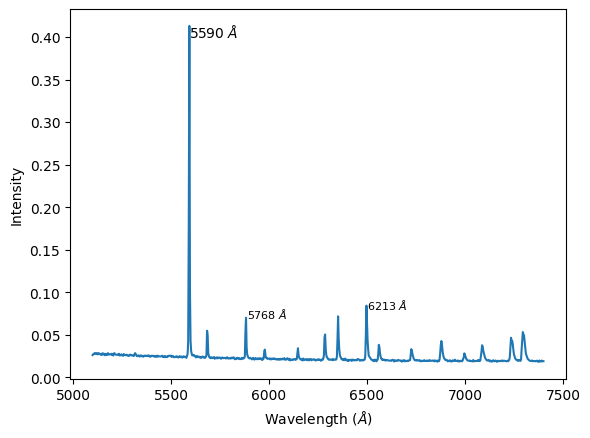

In [195]:
#4.4.6 - plot of the calibrated spectrum with labels on the emission lines
wave = np.array(a + b * xseq) # wavelengths from previous plot in nm
print(wave)
new2 = np.median(cut_arclamp_normed.data, axis = 0) # Intensity counts
xseq2 = np.linspace(510, 740, 765)*10 # the range of the wavelength data converted to Angstroms
wavelength = np.array(a + b * xseq2) # array of the calibrated wavelengths

plt.plot(xseq2, new2)
plt.text(5590, 0.40, r'5590 $\AA$', fontsize = 10)
plt.text(5890, 0.07, r'5768 $\AA$', fontsize = 8)
plt.text(6500, 0.08, r'6213 $\AA$', fontsize = 8)
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Intensity')

4.4.7 - The length of the spectrum that is covered by the spectrograph is 6835.6 angstroms and the dispersion is from 0-765.

4.5
In order to calibrate the images, we must subtract the master dark image for the 10-second exposure from the Saturn filter with a corresponding 10-second exposure. Then, divide this result by the master normed flat field. Repeat the same steps for each color filter for the Saturn images as well as the dark frame and flat fields, be sure to note that these image filters should all have 100-second exposure times. It is possible to take bias and dark frames on another date if they were not able to be taken on the observation date, however, the flat-fields are sensitive to changes in the environment so they must be acquired on the original observing date.

4.6 
Reduce the science image through the aforementioned calibration steps. Be sure to align the images using astropy since they have longer exposure times and thus the image is likely to be shifted in between each shot.

In [197]:
#4.6 reading in the Blue Flat fields
blue_flat1 = CCDData.read('flat_fields_frame_blue.00000015.FIT', unit='adu')
blue_flat2 = CCDData.read('flat_fields_frame_blue.00000016.FIT', unit='adu')
blue_flat3 = CCDData.read('flat_fields_frame_blue.00000017.FIT', unit='adu')
blue_flat4 = CCDData.read('flat_fields_frame_blue.00000018.FIT', unit='adu')
blue_flat5 = CCDData.read('flat_fields_frame_blue.00000019.FIT', unit='adu')
blue_flat6 = CCDData.read('flat_fields_frame_blue.00000020.FIT', unit='adu')
blue_flat7 = CCDData.read('flat_fields_frame_blue.00000021.FIT', unit='adu')
blue_flat8 = CCDData.read('flat_fields_frame_blue.00000022.FIT', unit='adu')
blue_flat9 = CCDData.read('flat_fields_frame_blue.00000023.FIT', unit='adu')
blue_flat10 = CCDData.read('flat_fields_frame_blue.00000024.FIT', unit='adu')
blue_flat11 = CCDData.read('flat_fields_frame_blue.00000025.FIT', unit='adu')
blue_flat12 = CCDData.read('flat_fields_frame_blue.00000026.FIT', unit='adu')

# taking the median combine of the blue flats and norming
combiner_blue_flats = Combiner([blue_flat1, blue_flat2, blue_flat3, blue_flat4, blue_flat5, blue_flat6, blue_flat7, blue_flat8, blue_flat9, blue_flat10, blue_flat11, blue_flat12])
combined_blue_median_flats = np.array(combiner_blue_flats.median_combine())
mean_blue_flats = np.mean(combined_blue_median_flats)
normed_blue = combined_blue_median_flats/mean_blue_flats

#4.6 - Making new FIT file from median array
hdu4 = fits.PrimaryHDU(normed_blue)
hdul4 = fits.HDUList([hdu4])
hdu4.writeto('master_blue_flat.FIT', overwrite = True)

final_blue_flat = CCDData.read('master_blue_flat.FIT', unit='adu')
#plt.imshow(final_blue_flat.data)

In [198]:
#4.6 reading in the red Flat fields
red_flat1 = CCDData.read('flat_fields_frame_red.00000027.FIT', unit='adu')
red_flat2 = CCDData.read('flat_fields_frame_red.00000028.FIT', unit='adu')
red_flat3 = CCDData.read('flat_fields_frame_red.00000029.FIT', unit='adu')
red_flat4 = CCDData.read('flat_fields_frame_red.00000030.FIT', unit='adu')
red_flat5 = CCDData.read('flat_fields_frame_red.00000031.FIT', unit='adu')
red_flat6 = CCDData.read('flat_fields_frame_red.00000032.FIT', unit='adu')
red_flat7 = CCDData.read('flat_fields_frame_red.00000033.FIT', unit='adu')
red_flat8 = CCDData.read('flat_fields_frame_red.00000034.FIT', unit='adu')
red_flat9 = CCDData.read('flat_fields_frame_red.00000035.FIT', unit='adu')
red_flat10 = CCDData.read('flat_fields_frame_red.00000036.FIT', unit='adu')
red_flat11 = CCDData.read('flat_fields_frame_red.00000037.FIT', unit='adu')
red_flat12 = CCDData.read('flat_fields_frame_red.00000038.FIT', unit='adu')
red_flat13 = CCDData.read('flat_fields_frame_red.00000039.FIT', unit='adu')

# taking the median combine of the red flats and norming
combiner_flats_red = Combiner([red_flat1, red_flat2, red_flat3, red_flat4, red_flat5, red_flat6, red_flat7, red_flat8, red_flat9, 
                               red_flat10, red_flat11, red_flat12, red_flat13])
combined_median_flats_red = np.array(combiner_flats_red.median_combine())
mean_flats_red = np.mean(combined_median_flats_red)
normed_red = combined_median_flats_red/mean_flats_red

hdu = fits.PrimaryHDU(normed_red)
hdul = fits.HDUList([hdu])
hdu.writeto('flat_red.FIT', overwrite = True)

final_red_flat = CCDData.read('flat_red.FIT', unit='adu')
#show_image(red_image_flat.data, cmap='inferno')

In [199]:
#Combining 10 dark images with 30s exposure time and finding median
saturn_bdark1 = CCDData.read('saturn_blue_darks.00000040.DARK.FIT', unit='adu')
saturn_bdark2 = CCDData.read('saturn_blue_darks.00000041.DARK.FIT', unit='adu')
saturn_bdark3 = CCDData.read('saturn_blue_darks.00000042.DARK.FIT', unit='adu')
saturn_bdark4 = CCDData.read('saturn_blue_darks.00000043.DARK.FIT', unit='adu')
saturn_bdark5 = CCDData.read('saturn_blue_darks.00000044.DARK.FIT', unit='adu')
saturn_bdark6 = CCDData.read('saturn_blue_darks.00000045.DARK.FIT', unit='adu')
saturn_bdark7 = CCDData.read('saturn_blue_darks.00000046.DARK.FIT', unit='adu')
saturn_bdark8 = CCDData.read('saturn_blue_darks.00000047.DARK.FIT', unit='adu')
saturn_bdark9 = CCDData.read('saturn_blue_darks.00000048.DARK.FIT', unit='adu')
saturn_bdark10 = CCDData.read('saturn_blue_darks.00000049.DARK.FIT', unit='adu')

combiner2 = Combiner([saturn_bdark1, saturn_bdark2, saturn_bdark3, saturn_bdark4, saturn_bdark5, saturn_bdark6, saturn_bdark7,
                     saturn_bdark8, saturn_bdark9, saturn_bdark10])
combined_median2 = np.array(combiner2.median_combine())

#Making new FIT file from median array
hdu = fits.PrimaryHDU(combined_median2)
hdul = fits.HDUList([hdu])
hdu.writeto('saturn_master_bdark1.DARK.FIT', overwrite = True)

#Master Blue Dark Frame for Saturn
dark_blue = CCDData.read('saturn_master_bdark1.DARK.FIT', unit='adu')
#plt.imshow(dark_blue.data)

In [200]:
#Combining 10 dark images for Saturn with a visible filter and finding median combine
saturn_vdark1 = CCDData.read('saturn_visible_darks.00000010.DARK.FIT', unit='adu')
saturn_vdark2 = CCDData.read('saturn_visible_darks.00000011.DARK.FIT', unit='adu')
saturn_vdark3 = CCDData.read('saturn_visible_darks.00000012.DARK.FIT', unit='adu')
saturn_vdark4 = CCDData.read('saturn_visible_darks.00000013.DARK.FIT', unit='adu')
saturn_vdark5 = CCDData.read('saturn_visible_darks.00000014.DARK.FIT', unit='adu')
saturn_vdark6 = CCDData.read('saturn_visible_darks.00000015.DARK.FIT', unit='adu')
saturn_vdark7 = CCDData.read('saturn_visible_darks.00000016.DARK.FIT', unit='adu')
saturn_vdark8 = CCDData.read('saturn_visible_darks.00000017.DARK.FIT', unit='adu')
saturn_vdark9 = CCDData.read('saturn_visible_darks.00000018.DARK.FIT', unit='adu')
saturn_vdark10 = CCDData.read('saturn_visible_darks.00000019.DARK.FIT', unit='adu')

combiner3 = Combiner([saturn_vdark1, saturn_vdark2, saturn_vdark3, saturn_vdark4, saturn_vdark5, saturn_vdark6, saturn_vdark7,
                     saturn_vdark8, saturn_vdark9, saturn_vdark10])
combined_median3 = np.array(combiner3.median_combine())

#Making new FIT file from median array
hdu = fits.PrimaryHDU(combined_median3)
hdul = fits.HDUList([hdu])
hdu.writeto('saturn_master_vdark1.DARK.FIT', overwrite = True)

#Master Saturn Visible Dark Frame
dark_visible = CCDData.read('saturn_master_vdark1.DARK.FIT', unit='adu')
#plt.imshow(dark_visible.data)

In [201]:
#Combining 10 dark images for Saturn with a blue filter and finding median combine
saturn_blue1 = CCDData.read('saturn_blue.00000030.FIT', unit='adu')
saturn_blue2 = CCDData.read('saturn_blue.00000031.FIT', unit='adu')
saturn_blue3 = CCDData.read('saturn_blue.00000032.FIT', unit='adu')
saturn_blue4 = CCDData.read('saturn_blue.00000033.FIT', unit='adu')
saturn_blue5 = CCDData.read('saturn_blue.00000034.FIT', unit='adu')
saturn_blue6 = CCDData.read('saturn_blue.00000035.FIT', unit='adu')
saturn_blue7 = CCDData.read('saturn_blue.00000036.FIT', unit='adu')
saturn_blue8 = CCDData.read('saturn_blue.00000037.FIT', unit='adu')
saturn_blue9 = CCDData.read('saturn_blue.00000038.FIT', unit='adu')
saturn_blue10 = CCDData.read('saturn_blue.00000039.FIT', unit='adu')

combiner4 = Combiner([saturn_blue1, saturn_blue2, saturn_blue3, saturn_blue4, saturn_blue5, saturn_blue6, saturn_blue7,
                     saturn_blue8, saturn_blue9, saturn_blue10])
combined_median4 = np.array(combiner4.median_combine())

#Making new FIT file from median array
hdu = fits.PrimaryHDU(combined_median4)
hdul = fits.HDUList([hdu])
hdu.writeto('master_saturn_blue1.FIT', overwrite = True)

#Master Saturn Blue Dark Frame
saturn_blue = CCDData.read('master_saturn_blue1.FIT', unit='adu')
#plt.imshow(saturn_blue.data)

In [202]:
#Combining images for Saturn with a Visible filter and finding median combine
saturn_visible1 = CCDData.read('saturn_visible.00000000.FIT', unit='adu')
saturn_visible2 = CCDData.read('saturn_visible.00000001.FIT', unit='adu')
saturn_visible3 = CCDData.read('saturn_visible.00000002.FIT', unit='adu')
saturn_visible4 = CCDData.read('saturn_visible.00000003.FIT', unit='adu')
saturn_visible5 = CCDData.read('saturn_visible.00000004.FIT', unit='adu')
saturn_visible6 = CCDData.read('saturn_visible.00000005.FIT', unit='adu')
saturn_visible7 = CCDData.read('saturn_visible.00000006.FIT', unit='adu')
saturn_visible8 = CCDData.read('saturn_visible.00000007.FIT', unit='adu')
saturn_visible9 = CCDData.read('saturn_visible.00000008.FIT', unit='adu')
saturn_visible10 = CCDData.read('saturn_visible.00000009.FIT', unit='adu')

combiner5 = Combiner([saturn_visible1, saturn_visible2, saturn_visible3, saturn_visible4, saturn_visible5, saturn_visible6, saturn_visible7,
                     saturn_visible8, saturn_visible9, saturn_visible10])
combined_median5 = np.array(combiner5.median_combine())

#Making new FIT file from median array
hdu = fits.PrimaryHDU(combined_median5)
hdul = fits.HDUList([hdu])
hdu.writeto('master_saturn_visible.FIT', overwrite = True)

#Master Saturn Visible Frame
saturn_visible = CCDData.read('master_saturn_visible.FIT', unit='adu')
#plt.imshow(saturn_visible.data)

In [203]:
#4.6 Combining images for Saturn with a red filter and finding median combine
saturn_red1 = CCDData.read('saturn_red.00000020.FIT', unit='adu')
saturn_red2 = CCDData.read('saturn_red.00000021.FIT', unit='adu')
saturn_red3 = CCDData.read('saturn_red.00000022.FIT', unit='adu')
saturn_red4 = CCDData.read('saturn_red.00000023.FIT', unit='adu')
saturn_red5 = CCDData.read('saturn_red.00000024.FIT', unit='adu')
saturn_red6 = CCDData.read('saturn_red.00000025.FIT', unit='adu')
saturn_red7 = CCDData.read('saturn_red.00000026.FIT', unit='adu')
saturn_red8 = CCDData.read('saturn_red.00000027.FIT', unit='adu')
saturn_red9 = CCDData.read('saturn_red.00000028.FIT', unit='adu')
saturn_red10 = CCDData.read('saturn_red.00000029.FIT', unit='adu')

combiner6 = Combiner([saturn_red1, saturn_red2, saturn_red3, saturn_red4, saturn_red5, saturn_red6, saturn_red7, 
                      saturn_red8, saturn_red9, saturn_red10])
combined_median6 = np.array(combiner6.median_combine())

#Making new FIT file from median array
hdu = fits.PrimaryHDU(combined_median6)
hdul = fits.HDUList([hdu])
hdu.writeto('master_saturn_red.FIT', overwrite = True)

#Master Saturn red Frame
saturn_red = CCDData.read('master_saturn_red.FIT', unit='adu')
#plt.imshow(saturn_red.data)

In [204]:
# calibrate the blue filter image
blue_sub = saturn_blue.data - dark_visible.data
#plt.imshow(blue_sub.data, cmap='inferno')
final_blue = blue_sub.data / final_blue_flat.data
#plt.imshow(final_blue, cmap='inferno')

In [205]:
# calibrate the red filter image
red_sub = saturn_red.data - dark_visible.data
#plt.imshow(red_sub.data, cmap='inferno')
final_red = red_sub.data / final_red_flat.data
#plt.imshow(final_red, cmap='inferno')

In [206]:
# calibrate the visible filter image
visible_sub = saturn_visible.data - dark_visible.data
#plt.imshow(visible_sub.data, cmap='inferno')
final_visible = visible_sub.data / flat_image.data
#plt.imshow(final_visible.data, cmap='inferno')

In [207]:
# shift the array data for the visible and the blue filter in order to align them
visible_array = np.roll(final_visible.data, (25, 23), axis = (1,0))
blue_array = np.roll(final_blue.data, (-30, -28), axis = (1,0))

In [208]:
# stacking the images using array math
stacked = np.array([final_red.data/final_red.max(), visible_array/visible_array.max(), blue_array/blue_array.max()])
np.shape(stacked)
stacked1 = np.zeros((1024,1024,3))
stacked1[:,:,0] = stacked[0]
stacked1[:,:,1] = stacked[1]
stacked1[:,:,2] = stacked[2]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(355.0, 500.0)

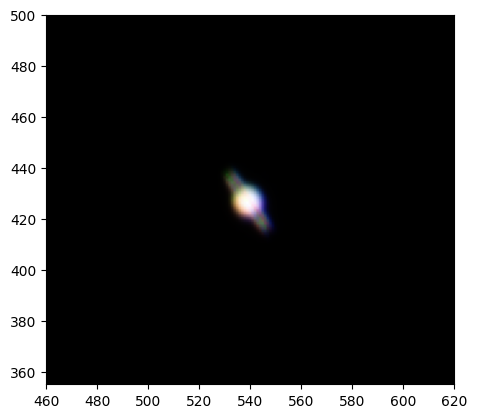

In [214]:
# print the final "pretty image" 
plt.imshow(stacked1,  cmap='inferno', vmin = np.mean(stacked1.data) - 3*(np.std(stacked1.data)), 
            vmax = np.mean(stacked1.data) + 3*(np.std(stacked1.data)))
plt.xlim(460,620)
plt.ylim(355,500)

4.6 
The final image appears to be blurry because there remains a slight difference between the location of Saturn in each image. This can be solved by interpolating the data, however, for the purposes of this lab, it is not necessary to do so. While the moons of Saturn are not visible using matplotlib, it is possible to upload the image to Ds9 and change the scale and filters to make them visible. 